# <center>Đồ án 3: Linear Regression</center>

# Thông tin sinh viên

- Họ và tên: Diệp Hữu Phúc
- MSSV: 21127135
- Lớp: 21CLC05

# Import

In [1]:
import pandas as pd
import numpy as np

# Import thêm dữ thư viện nếu cần
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Đọc dữ liệu

In [2]:
# Đọc dữ liệu bằng pandas
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Lấy các đặc trưng X và giá trị mục tiêu y cho các tập huấn luyện (train) và kiểm tra (test)
X_train = train.iloc[:, :-1]    # Dataframe (chứa các đặc trưng huấn luyện)
y_train = train.iloc[:, -1]     # Series    (chứa 1 giá trị mục tiêu kiểm tra)

X_test = test.iloc[:, :-1]      # Dataframe (chứa các đặc trưng kiểm tra)
y_test = test.iloc[:, -1]       # Series    (chứa 1 giá trị mục tiêu kiểm tra)

# Sinh viên có thể sử dụng các khác nếu cần
# 1a. 11 đặc trưng đầu tiên (Gender, ..., Domain)
X_1a_train = train.iloc[:, :11]
X_1a_test = test.iloc[:, :11]
# 1b. conscientiousness, agreeableness, extraversion, nueroticism, openess_to_experience
train_1b = train.loc[:, 'conscientiousness':]
# 1c. English, Logical, Quant
train_1c = train.loc[:, ['English', 'Logical', 'Quant', 'Salary']]

# Cài đặt hàm

In [3]:
# Cài đặt các hàm cần thiết ở đây
class OLSLinearRegression:
    def fit(self, X, y):
        X_pinv = np.linalg.inv(X.T @ X) @ X.T    # np.linalg.pinv(X)
        self.w = X_pinv @ y
        return self

    def get_params(self):
        return self.w

    def predict(self, X):
        return np.sum(self.w.ravel() * X, axis=1)

def mae(y, y_hat):
    return np.mean(np.abs(y.ravel() - y_hat.ravel()))

def kfold_traits(train:pd.DataFrame, k_fold:int=5, seed:int=42, trait_label:str='Trait'):
    '''
    > train:pd.DataFrame - The training set.
    > k_fold:int - The number of tests, or splits, or folds.
    > seed:int - The seed for random_state, use None for irreproducible results.
    > trait_label:str - The column name for the traits.
    < fit_trait:list - 1st element is the name of the fittest trait, 2nd is its avg_MAE.
    < avg_MAEs:pd.DataFrame - Table of every trait and its avg_MAE.
    '''
    split_MAEs = []
    traits = train.iloc[:, :-1].columns.values
    train_shuffle = train.sample(frac=1, replace=False, random_state=seed)
    train_splits = np.array_split(train_shuffle, k_fold)
    for i in range(k_fold):
        subtrain = pd.concat(train_splits[:i] + train_splits[i + 1:])
        X_subtrain = subtrain.iloc[:, :-1]
        y_subtrain = subtrain.iloc[:, -1]
        X_subtest = train_splits[i].iloc[:, :-1]
        y_subtest = train_splits[i].iloc[:, -1]

        MAEs = []
        for tr in traits:
            X_tr_train = pd.Series.to_frame(X_subtrain[tr])
            X_tr_test = pd.Series.to_frame(X_subtest[tr])
            model_tr = OLSLinearRegression().fit(X_tr_train, y_subtrain)
            y_tr_hat = model_tr.predict(X_tr_test)
            MAEs.append(mae(y_subtest, y_tr_hat))
        split_MAEs.append(MAEs)

    avg_MAEs = np.array(split_MAEs).mean(axis=0).tolist()
    avg_MAEs = [[tr, avg] for tr, avg in zip(traits, avg_MAEs)]
    fit_trait = sorted(avg_MAEs, key=lambda x: x[1])[0]
    avg_MAEs = pd.DataFrame(avg_MAEs, columns=[trait_label, 'Average MAE'])
    return fit_trait, avg_MAEs

def stepwise_regress(X_train:pd.DataFrame, y_train:pd.Series, pval_max:float=0.05):
    '''
    > X_train:pd.DataFrame - The training features set
    > y_train:pd.Series - The target variable, or feature, set
    > pval_max:float - The upper limit of p-values
    < sig_traits:list - Names of all the significant features
    '''
    X_st_train = X_train.copy()
    stats = sm.OLS(y_train, X_st_train).fit()
    while not all(stats.pvalues <= pval_max):
        trait_max = stats.pvalues[stats.pvalues == max(stats.pvalues)]
        X_st_train.drop(columns=trait_max.index[0], inplace=True)
        stats = sm.OLS(y_train, X_st_train).fit()
    return stats.model.exog_names + [y_train.name]

def corr_regress(X_train:pd.DataFrame, y_train:pd.Series, corr_max:float=0.9):
    '''
    > X_train:pd.DataFrame - The training features set
    > y_train:pd.Series - The target variable, or feature, set
    > corr_max:float - The upper limit of correlation values
    < corr_mat:pd.DataFrame - The correlation matrix
    < sat_traits:list - Names of all the satisfied features
    '''
    corr_mat = X_train.corr()
    columns = np.full((corr_mat.shape[0],), True, dtype=bool)
    for i in range(corr_mat.shape[0]):
        for j in range(i + 1, corr_mat.shape[0]):
            if corr_mat.iloc[i, j] >= corr_max:
                if columns[j]: columns[j] = False
    return corr_mat, X_train.columns[columns].to_numpy().tolist() + [y_train.name]

def kfold_models(model_builders:list, train:pd.DataFrame, k_fold:int=5, seed:int=42):
    '''
    > model_builders:list - Array of every model and its builder.
    > train:pd.DataFrame - The training set.
    > k_fold:int - The number of tests, or splits, or folds.
    > seed:int - The seed for random_state, use None for irreproducible results.
    < fit_model:list - 1st element is the name of the fittest model, 2nd is its avg_MAE.
    < avg_MAEs:pd.DataFrame - Table of every model and its avg_MAE.
    '''
    split_MAEs = []
    train_shuffle = train.sample(frac=1, replace=False, random_state=seed)
    train_splits = np.array_split(train_shuffle, k_fold)
    for i in range(k_fold):
        subtrain = pd.concat(train_splits[:i] + train_splits[i + 1:])
        X_subtrain = subtrain.iloc[:, :-1]
        y_subtrain = subtrain.iloc[:, -1]
        X_subtest = train_splits[i].iloc[:, :-1]
        y_subtest = train_splits[i].iloc[:, -1]

        MAEs = []
        for build in model_builders:
            model, X_mod_test = build[1](X_subtrain, y_subtrain, X_subtest)[:2]
            y_mod_hat = model.predict(X_mod_test)
            MAEs.append(mae(y_subtest, y_mod_hat))
        split_MAEs.append(MAEs)

    avg_MAEs = np.array(split_MAEs).mean(axis=0).tolist()
    models = [mod[0] for mod in model_builders]
    avg_MAEs = [[mod, avg] for mod, avg in zip(models, avg_MAEs)]
    fit_model = sorted(avg_MAEs, key=lambda x: x[1])[0]
    avg_MAEs = pd.DataFrame(avg_MAEs, columns=['Model', 'Average MAE'])
    for mod in model_builders:
        if fit_model[0] == mod[0]:
            fit_model.insert(1, mod[1])
            break
    return fit_model, avg_MAEs

# Yêu cầu 1a: Sử dụng toàn bộ 11 đặc trưng đầu tiên `Gender`, `10percentage`, `12percentage`, `CollegeTier`, `Degree`, `collegeGPA`, `CollegeCityTier`, `English`, `Logical`, `Quant`, `Domain` (2 điểm) 

In [4]:
# Phần code cho yêu cầu 1a
model_1a = OLSLinearRegression().fit(X_1a_train, y_train)
params_1a = model_1a.get_params()
params_1a.index = X_1a_train.columns.to_numpy()
params_1a

Gender            -22756.512821
10percentage         804.503156
12percentage        1294.654565
CollegeTier       -91781.897530
Degree             23182.388679
collegeGPA          1437.548672
CollegeCityTier    -8570.661985
English              147.858299
Logical              152.888476
Quant                117.221846
Domain             34552.286221
dtype: float64

In [5]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra
y_hat = model_1a.predict(X_1a_test)
print(f'MAE: {mae(y_test, y_hat)}')

MAE: 104863.77754033124


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -22756.513\times\text{Gender} + 804.503\times\text{10percentage} + 1294.655\times\text{12percentage} - 91781.898\times\text{CollegeTier} \\ + 23182.389\times\text{Degree} + 1437.549\times\text{collegeGPA} - 8570.662\times\text{CollegeCityTier} + 147.858\times\text{English} \\ + 152.888\times\text{Logical} + 117.222\times\text{Quant} + 34552.286\times\text{Domain}$$

# Yêu cầu 1b: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng tính cách với các đặc trưng tính cách gồm `conscientiousness`, `agreeableness`, `extraversion`, `nueroticism`, `openess_to_experience`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [6]:
# Phần code cho yêu cầu 1b
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu
fit_pers, avg_MAEs_pers = kfold_traits(train_1b, trait_label='Personality')
print(f'The fittest personality: {fit_pers[0]}')
avg_MAEs_pers

The fittest personality: nueroticism


,Personality,Average MAE
0,conscientiousness,306309.201775
1,agreeableness,300912.677678
2,extraversion,307030.102690
3,nueroticism,299590.049823
4,openess_to_experience,302957.691854


In [7]:
# Huấn luyện lại mô hình best_personality_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_pers_train = pd.Series.to_frame(X_train[fit_pers[0]])
best_personality_feature_model = OLSLinearRegression().fit(X_pers_train, y_train)
param_bp = best_personality_feature_model.get_params()
param_bp.index = X_pers_train.columns.to_numpy()
param_bp

nueroticism   -56546.303753
dtype: float64

In [8]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_personality_feature_model
X_pers_test = pd.Series.to_frame(X_test[fit_pers[0]])
y_hat = best_personality_feature_model.predict(X_pers_test)
print(f'MAE: {mae(y_test, y_hat)}')

MAE: 291019.693226953


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -56546.304\times\text{nueroticism}$$

# Yêu cầu 1c: Xây dựng mô hình sử dụng duy nhất 1 đặc trưng `English`, `Logical`, `Quant`, tìm mô hình cho kết quả tốt nhất (1 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ đặc trưng

In [9]:
# Phần code cho yêu cầu 1c
# Tìm ra đặc trưng tốt nhất
# In ra các kết quả cross-validation như yêu cầu
fit_sk, avg_MAEs_sk = kfold_traits(train_1c, trait_label='Skill')
print(f'The fittest skill: {fit_sk[0]}')
avg_MAEs_sk

The fittest skill: Quant


,Skill,Average MAE
0,English,121925.884315
1,Logical,120274.777737
2,Quant,118124.524456


In [10]:
# Huấn luyện lại mô hình best_skill_feature_model với đặc trưng tốt nhất trên toàn bộ tập huấn luyện
X_sk_train = pd.Series.to_frame(X_train[fit_sk[0]])
best_skill_feature_model = OLSLinearRegression().fit(X_sk_train, y_train)
param_bs = best_skill_feature_model.get_params()
param_bs.index = X_sk_train.columns.to_numpy()
param_bs

Quant    585.895381
dtype: float64

In [11]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình best_skill_feature_model
X_sk_test = pd.Series.to_frame(X_test[fit_sk[0]])
y_hat = best_skill_feature_model.predict(X_sk_test)
print(f'MAE: {mae(y_test, y_hat)}')

MAE: 106819.57761989674


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = 585.895\times\text{Quant}$$

# Yêu cầu 1d: Sinh viên tự xây dựng mô hình, tìm mô hình cho kết quả tốt nhất (3 điểm)

Lưu ý: khi sử dụng cross-validation, sinh viên cần xáo trộn dữ liệu 1 lần duy nhất và thực hiện trên toàn bộ $m$ mô hình mà sinh viên thiết kế

## Tìm mô hình

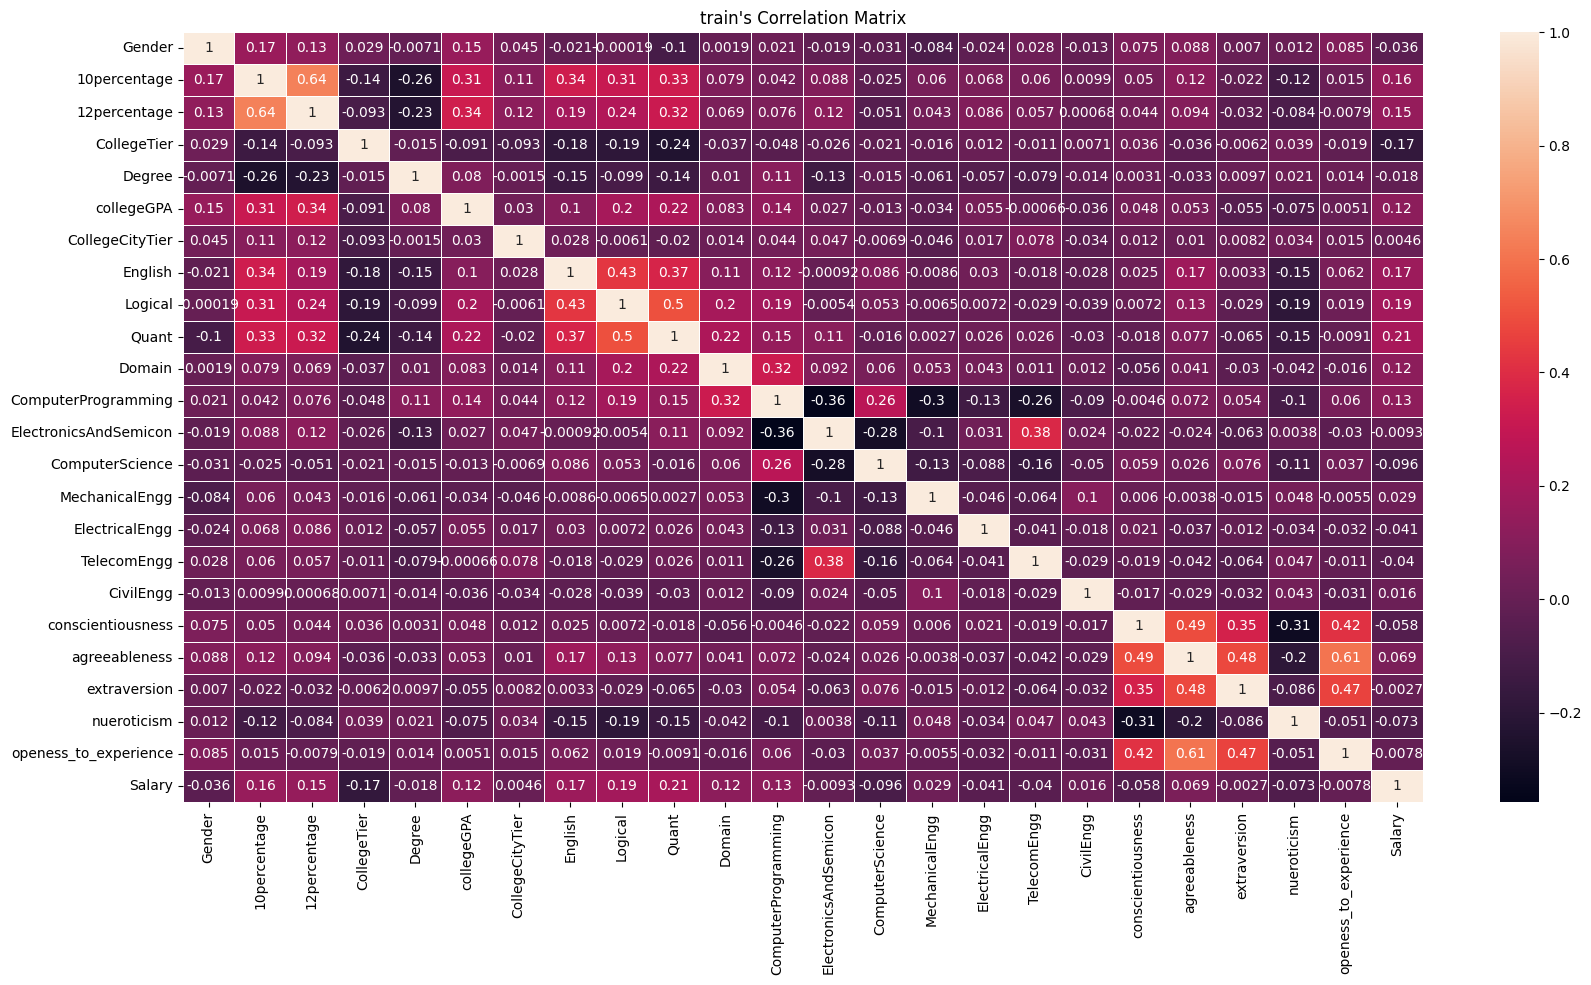

In [12]:
# Trình bày các phần tìm ra mô hình
# MODEL 1 [rf_1dm1] - Using Stepwise Regression to filter out unimportant features.
def build_1dm1_stepReg(X_train:pd.DataFrame, y_train:pd.Series, X_test:pd.DataFrame):
    traits = stepwise_regress(X_train, y_train)
    X_1dm1_train = X_train.loc[:, traits[:-1]]
    X_1dm1_test = X_test.loc[:, traits[:-1]]
    model_1dm1 = OLSLinearRegression().fit(X_1dm1_train, y_train)
    return model_1dm1, X_1dm1_test

# MODEL 2 [rf_1dm2] - Using Correlation Matrix to remove features. For every pair of
#   features having high correlation value, one of the two will be discarded.
def build_1dm2_corrMat(X_train:pd.DataFrame, y_train:pd.Series, X_test:pd.DataFrame):
    corr_mat, traits = corr_regress(X_train, y_train)
    X_1dm2_train = X_train.loc[:, traits[:-1]]
    X_1dm2_test = X_test.loc[:, traits[:-1]]
    model_1dm2 = OLSLinearRegression().fit(X_1dm2_train, y_train)
    return model_1dm2, X_1dm2_test, corr_mat

corr_mat = train.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(corr_mat, annot=True, linewidths=.5)
plt.title('train\'s Correlation Matrix')
# plt.savefig("plot.pdf", format="pdf", bbox_inches="tight")
plt.show()

# MODEL 3 - Grouping features based on semantics. This model is quite silly, it drew
#   inspiration from the above tasks.
def build_1dm3_featGroup(X_train:pd.DataFrame, y_train:pd.Series, X_test:pd.DataFrame):
    X_1dm3_train = pd.concat([X_train.loc[:, 'Gender':'CollegeCityTier'].sum(axis=1),
                            X_train.loc[:, 'English':'Quant'].sum(axis=1),
                            X_train.loc[:, 'Domain':'CivilEngg'].sum(axis=1),
                            X_train.loc[:, 'conscientiousness':'openess_to_experience'].sum(axis=1)],
                            axis=1, keys=['Gen2Col', 'Eng2Qua', 'Dom2Civ', 'con2ope'])
    X_1dm3_test = pd.concat([X_test.loc[:, 'Gender':'CollegeCityTier'].sum(axis=1),
                            X_test.loc[:, 'English':'Quant'].sum(axis=1),
                            X_test.loc[:, 'Domain':'CivilEngg'].sum(axis=1),
                            X_test.loc[:, 'conscientiousness':'openess_to_experience'].sum(axis=1)],
                            axis=1, keys=['Gen2Col', 'Eng2Qua', 'Dom2Civ', 'con2ope'])
    model_1dm3 = OLSLinearRegression().fit(X_1dm3_train, y_train)
    return model_1dm3, X_1dm3_test

# MODEL 4 [rf_1dm2] - Combining Correlation Matrix and Stepwise Regression.
def build_1dm4_corrStep(X_train:pd.DataFrame, y_train:pd.Series, X_test:pd.DataFrame):
    corr_mat, traits = corr_regress(X_train, y_train)
    X_corr_train = X_train.loc[:, traits[:-1]]
    X_corr_test = X_test.loc[:, traits[:-1]]
    return list(build_1dm1_stepReg(X_corr_train, y_train, X_corr_test)) + [corr_mat]

## Thử nghiệm, so sánh các mô hình

In [13]:
# Phần code cho yêu cầu 1d
# Tìm ra mô hình tốt nhất (tự thiết kế bởi sinh viên)
# In ra các kết quả cross-validation như yêu cầu
model_builders = [['1dm1 Stepwise Regression', build_1dm1_stepReg],
                  ['1dm2 Correlation Matrix', build_1dm2_corrMat],
                  ['1dm3 Feature Grouping', build_1dm3_featGroup],
                  ['1dm4 Correlation & Stepwise', build_1dm4_corrStep]]
fit_model, avg_MAEs = kfold_models(model_builders, train)
print(f'The fittest model: {fit_model[0]}')
avg_MAEs

The fittest model: 1dm2 Correlation Matrix


,Model,Average MAE
0,1dm1 Stepwise Regression,110684.299652
1,1dm2 Correlation Matrix,110420.413776
2,1dm3 Feature Grouping,115207.564242
3,1dm4 Correlation & Stepwise,110684.299652


In [14]:
# Huấn luyện lại mô hình my_best_model trên toàn bộ tập huấn luyện
my_best_model, X_bm_test = fit_model[1](X_train, y_train, X_test)[:2]
params_bm = my_best_model.get_params()
params_bm.index = X_bm_test.columns.to_numpy()
params_bm

Gender                  -23874.541726
10percentage               898.575621
12percentage              1203.496112
CollegeTier             -83592.387591
Degree                   11515.430757
collegeGPA                1626.518605
CollegeCityTier          -5717.733852
English                    153.434567
Logical                    120.511333
Quant                      102.580853
Domain                   27939.639602
ComputerProgramming         76.730246
ElectronicsAndSemicon      -47.746793
ComputerScience           -177.387649
MechanicalEngg              33.932559
ElectricalEngg            -151.471153
TelecomEngg                -64.197706
CivilEngg                  145.894996
conscientiousness       -19814.830268
agreeableness            15503.266941
extraversion              4908.582006
nueroticism             -10661.029100
openess_to_experience    -5815.021280
dtype: float64

In [15]:
# Gọi hàm MAE (tự cài đặt hoặc từ thư viện) trên tập kiểm tra với mô hình my_best_model
y_bm_hat = my_best_model.predict(X_bm_test)
print(f'MAE: {mae(y_test, y_bm_hat)}')

MAE: 101872.21056619247


Công thức hồi quy (phần trọng số làm tròn đến 3 chữ số thập phân, ví dụ 0.012345 $\to$ 0.012)

$$\text{Salary} = -23874.542\times\text{Gender} + 898.576\times\text{10percentage} + 1203.496\times\text{12percentage} - 83592.388\times\text{CollegeTier} \\ + 11515.431\times\text{Degree} + 1626.519\times\text{collegeGPA} - 5717.734\times\text{CollegeCityTier} + 153.435\times\text{English} \\ + 120.511\times\text{Logical} + 102.581\times\text{Quant} + 27939.640\times\text{Domain} + 76.730\times\text{ComputerProgramming} \\ - 47.747\times\text{ElectronicsAndSemicon} - 177.388\times\text{ComputerScience} + 33.933\times\text{MechanicalEngg} \\ - 151.471\times\text{ElectricalEngg} - 64.198\times\text{TelecomEngg} + 145.895\times\text{CivilEngg} \\ - 19814.830\times\text{conscientiousness} + 15503.267\times\text{agreeableness} + 4908.582\times\text{extraversion} \\ - 10661.029\times\text{nueroticism} - 5815.021\times\text{openess\_to\_experience}$$

# References

## 1a. First 11 features (Gender, ..., Domain)
- `lab04.ipynb` provided by Lecturer Phan Thị Phương Uyên.

## 1b, 1c. Five personality features, three skill features
- https://scikit-learn.org/stable/modules/cross_validation.html
- https://grsahagian.medium.com/what-is-random-state-42-d803402ee76b
- https://stackoverflow.com/a/17315875

## 1d. Building models and finding the best one
### Model 1 - Stepwise Regression
- https://youtu.be/-inJu1jHqb8
- https://youtu.be/An40g_j1dHA
- https://towardsdatascience.com/stepwise-regression-tutorial-in-python-ebf7c782c922 [rf_1dm1]
- https://stackoverflow.com/a/30523731
- https://stackoverflow.com/q/11836286

### Model 2 - Correlation Matrix
- https://androidkt.com/find-correlation-between-features-and-target-using-the-correlation-matrix/
- https://vishalramesh.substack.com/p/feature-selection-correlation-and-p-value-da8921bfb3cf?s=w [rf_1dm2]

### Model 3 - Feature Grouping
- https://stackoverflow.com/a/42063749

## Appendix A: Concepts that I failed to implement
- https://youtu.be/fyRubPKgVoY
- https://stats.stackexchange.com/a/18852
- https://stats.stackexchange.com/a/11373
- https://machinelearningmastery.com/how-to-transform-target-variables-for-regression-with-scikit-learn/
- https://towardsdatascience.com/feature-transformation-for-multiple-linear-regression-in-python-8648ddf070b8